# Weather Data Analysis

Weather patterns are some of the most impactful phenomenons to exist in the natural order of our planet. Entire societies can be effected by weather, and with climate change discussions becoming much more frequent on the global stage, particularly regarding global warming, one should have an elementary understanding of these weather patterns.

I've been meaning to use Pandas in a practical project, and this provides the perfect opportunity. Please remember that this is a passion side-project, and does not go into the depth and rigour required to understand weather patterns from a temporal or spatial POV. Due to the short length of the notebook, there's not much need to organize the preliminary information in a detailed manner, so I've listed key points below for your convenience:

1. Data sources:
   - [station details](https://geographic.org/global_weather/ontario/toronto_city_355.html)
   - [original source of dataset](https://www.ncei.noaa.gov/access/past-weather/toronto)
2. Technologies used:
   - Python
   - Pandas
   - NumPy
   - Seaborn
   - Jupyter Notebook
3. Analysis Methods used:
   - Forward Fill (missing data estimation)
   - Monthly Averages (missing data estimation)
   - Descriptive Statistics
   - ...
   - ...

I hope you enjoy, and please feel free to reach out if you notice any errors or misinterpretations on my part :)

<h1> 1. Getting familiar with the data </h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
df = pd.read_csv("./source.csv", parse_dates=True)
df

,Date,TAVG,TMAX,TMIN,PRCP,SNWD
0,2002-06-04,NaN,57.0,48.0,0.19,NaN
1,2002-06-05,NaN,74.0,52.0,0.13,NaN
2,2002-06-06,NaN,64.0,55.0,0.00,NaN
3,2002-06-07,NaN,71.0,52.0,0.00,NaN
4,2002-06-08,NaN,77.0,53.0,0.00,NaN
...,...,...,...,...,...,...
7838,2023-12-27,46.0,47.0,45.0,0.65,NaN
7839,2023-12-28,45.0,46.0,43.0,0.13,NaN
7840,2023-12-29,41.0,45.0,37.0,0.18,0.0
7841,2023-12-30,34.0,37.0,31.0,0.00,NaN


Fortunately, the provided dataset's columns are rather trivial to understand. First, we have a unique id value for every row. All records listed were recorded by Toronto-based Meteorological Station CA006158355. Further details of the source meteorological are as follow:

1. ID: CA006158355
2. Name: TORONTO CITY, ON CA
3. Latitude (degrees): 43.6667
4. Longitude (degrees): -79.4000
5. Elevation (meters): 113.0

Each row represents a weather entry taken daily by the station, with it recording the TAVG, TMAX, TMIN, PRCP, and SNWD values of that day, all defined below:

1. TAVG: Average Temperature (Fahrenheit)
2. TMAX: Maximum Temperature (Fahrenheit)
3. TMIN: Minimum Temperature (Fahrenheit)
4. PRCP: Precipitation Level (Inches)
5. SNWD: Snow Depth (Inches)

Now that we are familiar with the dataset and its entries, we can move onto cleaning and preprocessing the data!

<h1> 2. Data Cleaning </h1>
Data cleaning is an important aspect of any data analysis since it ensures the accuracy of the dataset, leading to more trustworthy calculations.

<h3> 2.1 Removing unwanted column series </h3>

In [2]:
# drop the columns using .drop(), and inplace=True to modify the current df and not create a new one with the changes
df.drop('SNWD', axis=1, inplace=True)
df.head()

,Date,TAVG,TMAX,TMIN,PRCP
0,2002-06-04,NaN,57.0,48.0,0.19
1,2002-06-05,NaN,74.0,52.0,0.13
2,2002-06-06,NaN,64.0,55.0,0.00
3,2002-06-07,NaN,71.0,52.0,0.00
4,2002-06-08,NaN,77.0,53.0,0.00


Due to the dataset missing massive amounts of snow depth data, as well as it not really pertaining to our temperature study, I've opted to remove the SNWD column, although it could have its uses such as in determining trends between average temperature and depth of sitting snow.

After dropping those columns, the head of the modified data frame can be seen above

<h3> 2.2 Converting from the Imperial to Metric Measurement System </h3>

In [3]:
# Convert temperatures from Fahrenheit to Celsius
df['TAVG'] = ((df['TAVG'] - 32) * 5/9).round(1)
df['TMAX'] = ((df['TMAX'] - 32) * 5/9).round(1)
df['TMIN'] = ((df['TMIN'] - 32) * 5/9).round(1)
# Convert rainfall from inches to mm
df['PRCP'] = (df['PRCP'] * 25.4).round(1)

df

,Date,TAVG,TMAX,TMIN,PRCP
0,2002-06-04,NaN,13.9,8.9,4.8
1,2002-06-05,NaN,23.3,11.1,3.3
2,2002-06-06,NaN,17.8,12.8,0.0
3,2002-06-07,NaN,21.7,11.1,0.0
4,2002-06-08,NaN,25.0,11.7,0.0
...,...,...,...,...,...
7838,2023-12-27,7.8,8.3,7.2,16.5
7839,2023-12-28,7.2,7.8,6.1,3.3
7840,2023-12-29,5.0,7.2,2.8,4.6
7841,2023-12-30,1.1,2.8,-0.6,0.0


<h3> 2.3 Filling missing data (1 missing T... parameter) </h3>

In [4]:
# Count the number of rows with exactly one missing value among TMIN, TMAX, TAVG
num_rows_missing_one_value = df[['TMIN', 'TMAX', 'TAVG']].isnull().sum(axis=1).eq(1).sum()

print(f"Number of rows with exactly one missing value: {num_rows_missing_one_value}")

Number of rows with exactly one missing value: 801


Here we see that there is quite a lot of missing data in the data frame. To handle rows missing 1 parameter (from TMIN, TMAX, or TAVG), we will calculate that parameter as such:

1. TAVG : the mean of TMIN and TMAX
2. TMAX : 2 * TAVG - TMIN
3. TMIN : 2 * TAVG - TMAX

In [5]:
# fill the NaN values for TAVG with the mean of TMIN and TMAX (for each row => axis=1), alter the existing dataset inplace
# make sure TMIN and TMAX aren't NaN
df['TAVG'].fillna(df[['TMIN', 'TMAX']].mean(axis=1).where(df['TMIN'].notna() & df['TMAX'].notna()), inplace=True)
# fill the NaN values for TMAX with the formula TMAX : 2 * TAVG - TMIN, make sure TMIN and TAVG aren't NaN
df['TMAX'].fillna((2 * df['TAVG'] - df['TMIN']).where(df['TAVG'].notna() & df['TMIN'].notna()), inplace=True)
# fill the NaN values for TMIN with the formula TMIN : 2 * TAVG - TMAX, make sure TMAX and TAVG aren't NaN
df['TMIN'].fillna((2 * df['TAVG'] - df['TMAX']).where(df['TAVG'].notna() & df['TMAX'].notna()), inplace=True)

# round to 1 decimal
df['TAVG'] = df['TAVG'].round(1)
df['TMAX'] = df['TMAX'].round(1)
df['TMIN'] = df['TMIN'].round(1)

num_rows_missing_one_value = df[['TMIN', 'TMAX', 'TAVG']].isnull().sum(axis=1).eq(1).sum()

print(f"Number of rows with exactly one missing value: {num_rows_missing_one_value}")
df

Number of rows with exactly one missing value: 0


,Date,TAVG,TMAX,TMIN,PRCP
0,2002-06-04,11.4,13.9,8.9,4.8
1,2002-06-05,17.2,23.3,11.1,3.3
2,2002-06-06,15.3,17.8,12.8,0.0
3,2002-06-07,16.4,21.7,11.1,0.0
4,2002-06-08,18.4,25.0,11.7,0.0
...,...,...,...,...,...
7838,2023-12-27,7.8,8.3,7.2,16.5
7839,2023-12-28,7.2,7.8,6.1,3.3
7840,2023-12-29,5.0,7.2,2.8,4.6
7841,2023-12-30,1.1,2.8,-0.6,0.0


As we can see, all values in the dataframe now have their TAVG, TMIN, TMAX values. 

<h3> 2.4 Filling missing data (2+ missing T... parameters) </h3>

In [6]:
# Count the number of rows with two or more missing values among TMIN, TMAX, TAVG
num_rows_missing_two_or_more = (df[['TMIN', 'TMAX', 'TAVG']].isnull().sum(axis=1) >= 2).sum()

print(f"Number of rows where 2 or more of TMIN, TMAX, TAVG are NaN: {num_rows_missing_two_or_more}")

Number of rows where 2 or more of TMIN, TMAX, TAVG are NaN: 68


To handle rows missing 2+ parameters (from TMIN, TMAX, or TAVG), we cannot solely rely on calculating from 1 row, since 1 parameter cannot give us 2 more. Due to the simplicity of this analysis, we will calculate the parameters by factoring in the temperature of the previous day, known as Forward Fill. However I will come back to this once I have more time and fill in the missing data with much more accurate estimates, perhaps using a regression model or seasonal decomposition (time series).

In [7]:
# Forward fill missing values in TMIN, TMAX, TAVG
df[['TMIN', 'TMAX', 'TAVG']] = df[['TMIN', 'TMAX', 'TAVG']].ffill()

# Count the number of rows with two or more missing values among TMIN, TMAX, TAVG
num_rows_missing_two_or_more = (df[['TMIN', 'TMAX', 'TAVG']].isnull().sum(axis=1) >= 2).sum()
print(f"Number of rows where 2 or more of TMIN, TMAX, TAVG are NaN: {num_rows_missing_two_or_more}")

Number of rows where 2 or more of TMIN, TMAX, TAVG are NaN: 0


We now see that there are 0 rows missing 2 or more of TMIN, TMAX, or TAVG, implying we have successfully filled all missing data

<h3> 2.5 Filling missing data (PRCP) </h3>

In [8]:
# Count the number of rows missing the PRCP value
num_rows_missing_one_value = df[['PRCP']].isnull().sum(axis=1).eq(1).sum()

print(f"Number of rows missing the PRCP value: {num_rows_missing_one_value}")

Number of rows missing the PRCP value: 157


Missing PRCP data is present in only 157 entries, meaning only 0.02% of the data will be affected by the changes made via estimation, and hopefully not skew any future analysis on a significant scale.

In [9]:
# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Extract the month
df['Month'] = df['Date'].dt.month
# get the monthly PRCP averages
monthly_averages = df.groupby('Month')['PRCP'].mean()
# fill all the missing PRCP entries with the monthly averages
df['PRCP'] = df['PRCP'].fillna(df['Month'].map(monthly_averages))
# drop the temporary 'Month' column
df.drop('Month', axis=1, inplace=True)
df.tail()

,Date,TAVG,TMAX,TMIN,PRCP
7838,2023-12-27,7.8,8.3,7.2,16.5
7839,2023-12-28,7.2,7.8,6.1,3.3
7840,2023-12-29,5.0,7.2,2.8,4.6
7841,2023-12-30,1.1,2.8,-0.6,0.0
7842,2023-12-31,0.6,1.7,-1.1,2.3


In [10]:
# Count the number of rows missing the PRCP value
num_rows_missing_one_value = df[['PRCP']].isnull().sum(axis=1).eq(1).sum()

print(f"Number of rows missing the PRCP value: {num_rows_missing_one_value}")

Number of rows missing the PRCP value: 0


We now see that there are 0 rows missing PRCP data, implying we have successfully filled all missing PRCP data using monthly averages

<h1> 3. Data Analysis </h1>
With a cleaned dataset, we are now able to perform various tests to identify trends and patterns.

<h3> 3.1 Basic Descriptive Statistics </h3>

In [11]:
# Extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year
# The statistics I wish to show - can be customized by the user, here is a full list of available statistics:
# Count: Number of non-null values.
# Mean: Mean (average) of the values.
# Std: Standard deviation, a measure of the amount of variation or dispersion.
# Min: Minimum value.
# 25%: First quartile, or 25th percentile.
# 50% (or Median): Second quartile, or 50th percentile.
# 75%: Third quartile, or 75th percentile.
# Max: Maximum value.

custom_statistics = ['mean', 'std', 'min', 'max']
# Group by year and calculate descriptive statistics
yearly_stats = df.groupby('Year').agg({
    'TAVG': custom_statistics,
    'TMAX': custom_statistics,
    'TMIN': custom_statistics,
    'PRCP': custom_statistics
})

yearly_stats

TAVG                              TMAX                         \
           mean        std   min   max       mean        std   min   max   
Year                                                                       
2002  14.334286  10.156953  -9.7  30.0  18.516190  11.129186  -4.4  35.0   
2003   8.768611  10.603707 -17.0  27.0  12.692778  11.176991 -12.8  33.3   
2004   6.410109  13.456158 -27.8  26.1  12.863388  10.565289 -16.1  32.8   
2005   9.975890  11.103173 -18.3  29.4  13.755068  11.869478 -15.6  34.4   
2006  10.478904   9.086022  -9.4  30.6  14.135068   9.655385  -7.2  36.7   
2007   9.811781  10.774999 -16.1  28.3  13.642192  11.636912 -13.3  34.4   
2008   9.274317   9.911634 -13.3  26.1  13.179508  10.529876  -9.4  33.3   
2009   9.128022   9.766722 -14.4  27.2  12.864286  10.238876 -12.2  32.2   
2010  10.468219  10.168386 -14.4  28.3  14.270411  10.936533  -9.4  34.4   
2011  10.142466  10.355071 -14.4  31.1  13.861096  10.997865 -10.6  38.3   
2012  11.396712   9.391061 -11.7  30.0  15.311507  10.195117 -10.6  36.7   
2013   9.387945  10.166567 -14.4  29.4  13.155890  10.803942 -11.1  35.6   
2014   8.479121  10.940828 -17.8  26.7  12.220330  11.412736 -15.6  30.6   
2015   9.420994  11.001111 -20.6  27.2  13.407459  11.481563 -19.4  32.8   
2016  10.848493  10.534990 -19.4  28.3  14.928767  11.368845 -14.4  35.6   
2017   9.988827   9.958155 -17.2  26.7  13.810615  10.643450 -13.9  31.7   
2018   9.776751  10.637014 -18.9  27.8  13.534174  11.289717 -15.6  32.8   
2019   8.975758  10.351180 -17.8  27.8  12.775482  10.803965 -14.4  33.9   
2020  10.458953   9.745332 -13.3  29.4  14.319008  10.573280  -7.8  35.6   
2021  10.821271   9.906019 -10.6  28.3  14.613260  10.536581  -8.3  33.3   
2022   9.828571  10.600946 -16.7  27.8  13.833516  11.134390 -12.8  35.6   
2023  10.854121   9.007744 -15.0  26.7  14.504396   9.762552  -9.4  32.8   

           TMIN                             PRCP                       
           mean        std   min   max      mean       std  min   max  
Year                                                                   
2002  10.150476   9.352482 -15.0  25.0  1.620781  4.565732  0.0  34.8  
2003   4.873056  10.270190 -23.3  21.1  2.178232  4.832241  0.0  26.7  
2004   5.197814   9.976383 -23.3  21.7  1.760558  3.638422  0.0  25.7  
2005   6.117534  10.752609 -22.8  26.1  1.926094  4.923996  0.0  31.8  
2006   6.869589   8.664864 -13.3  24.4  2.623836  6.434600  0.0  44.7  
2007   5.895342  10.238204 -21.1  23.3  1.665434  4.971469  0.0  61.2  
2008   5.474317   9.598150 -16.7  22.8  2.616868  5.604279  0.0  52.1  
2009   5.367857   9.623959 -19.4  23.9  2.421893  5.874632  0.0  34.8  
2010   6.688219   9.655090 -17.8  24.4  2.052244  5.730420  0.0  45.0  
2011   6.383288   9.972287 -18.3  25.0  2.510685  5.540468  0.0  47.0  
2012   7.381644   8.713745 -14.4  23.9  2.294822  5.506769  0.0  45.5  
2013   5.580274   9.832618 -18.3  25.0  2.856004  7.766757  0.0  96.8  
2014   4.488187  10.730798 -22.2  22.8  2.032098  4.741705  0.0  34.0  
2015   5.274862  10.843766 -25.0  22.8  1.940817  5.601969  0.0  58.4  
2016   6.745479   9.804757 -24.4  25.0  1.864214  4.471356  0.0  47.5  
2017   6.208101   9.445670 -20.0  21.7  2.216163  5.503504  0.0  52.8  
2018   6.000000  10.220988 -22.2  23.3  2.651351  6.571416  0.0  58.2  
2019   5.192837  10.096947 -21.7  22.8  2.515822  5.586547  0.0  33.0  
2020   6.567493   9.132810 -18.9  23.9  2.259445  5.037486  0.0  55.4  
2021   7.020166   9.509969 -13.3  23.9  2.077348  5.196471  0.0  49.8  
2022   5.785989  10.258338 -20.6  23.3  2.006868  5.756145  0.0  39.9  
2023   7.218681   8.487757 -20.6  22.2  2.278297  5.392516  0.0  50.0

The table above shows the daily average temperature and precipitation statistics for every year, namely the mean, minimum, maximum, and standard deviation.

In [12]:
yearly_df = df[df['Year'] == 2016]
custom_statistics = ['mean', 'min', 'max']
yearly_stats = yearly_df.groupby('Year').agg({
    'TAVG': custom_statistics,
    'TMAX': custom_statistics,
    'TMIN': custom_statistics,
    'PRCP': custom_statistics
})
yearly_stats = yearly_stats.round(1)
yearly_stats

TAVG              TMAX             TMIN             PRCP           
      mean   min   max  mean   min   max mean   min   max mean  min   max
Year                                                                     
2016  10.8 -19.4  28.3  14.9 -14.4  35.6  6.7 -24.4  25.0  1.9  0.0  47.5

 The above table provides a more detailed look for the statistics of every year, and users can change the year value to see the various temperatures. However, the most intuitive way to see patterns is not by tables but rather the graphs below.

In [13]:
# Convert the 'DATE' column to a datetime format if not already
df['Date'] = pd.to_datetime(df['Date'])

# Create new columns for year and month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Group by year and month and calculate the monthly averages
dfm = df.groupby(['Year', 'Month']).agg({
    'TAVG': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean',
    'PRCP': 'mean'
}).reset_index()

dfm.columns = ['Year', 'Month', 'M_TAVG', 'M_TMAX', 'M_TMIN', 'M_PRCP']

dfm.head()

,Year,Month,M_TAVG,M_TMAX,M_TMIN,M_PRCP
0,2002,6,20.196296,24.992593,15.392593,1.788889
1,2002,7,24.393548,29.432258,19.354839,2.748387
2,2002,8,22.854839,27.748387,17.958065,0.503226
3,2002,9,20.655172,25.720690,15.586207,1.897459
4,2002,10,9.774194,13.325806,6.232258,1.381888


While having daily weather data provides a lot of data points, it becomes difficult to calculate with. What I've done above is calculate the average monthly values of TAVG, TMAX, TMIN, and PRCP for easier analysis in the rest of this section.

<Figure size 1000x600 with 0 Axes>

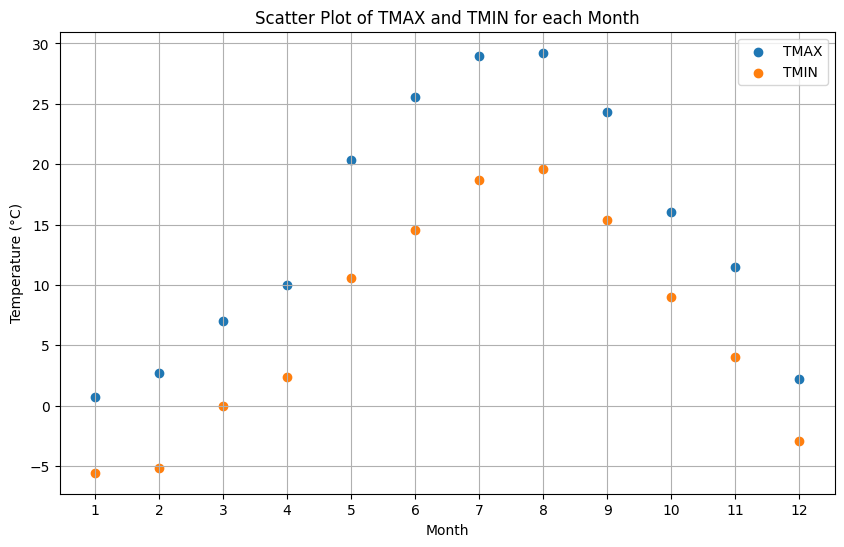

In [14]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6))
# Choose year
dfy = dfm[dfm['Year'] == 2016]
# Plotting the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot for TMAX values
plt.scatter(dfy['Month'], dfy['M_TMAX'], label='TMAX', marker='o')
# Scatter plot for TMIN values
plt.scatter(dfy['Month'], dfy['M_TMIN'], label='TMIN', marker='o')

plt.title('Scatter Plot of TMAX and TMIN for each Month')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(dfy['Month'])
plt.show()

Above is the plotting of TMAX and TMIN values for every month throughout the year. We can clearly see that at the start, both values are relatively row and near 0°C. As Spring comes, both values slowly rise but roughly during the middle of summer, they reach peak temperature and begin the descend.

<h3> 3.2 Time Series Plots </h3>

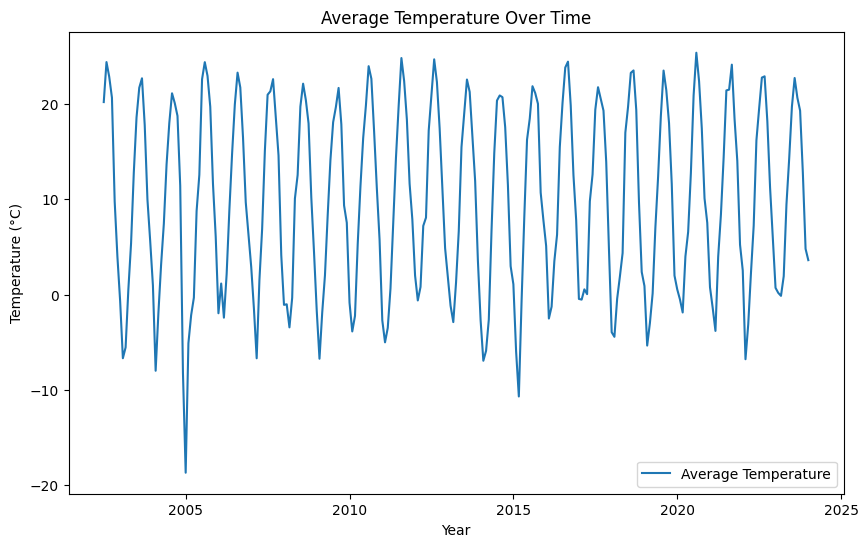

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(dfm['Year'] + dfm['Month']/12, dfm['M_TAVG'], label='Average Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature Over Time')
plt.legend()
plt.show()

<h3> 3.3 </h3>

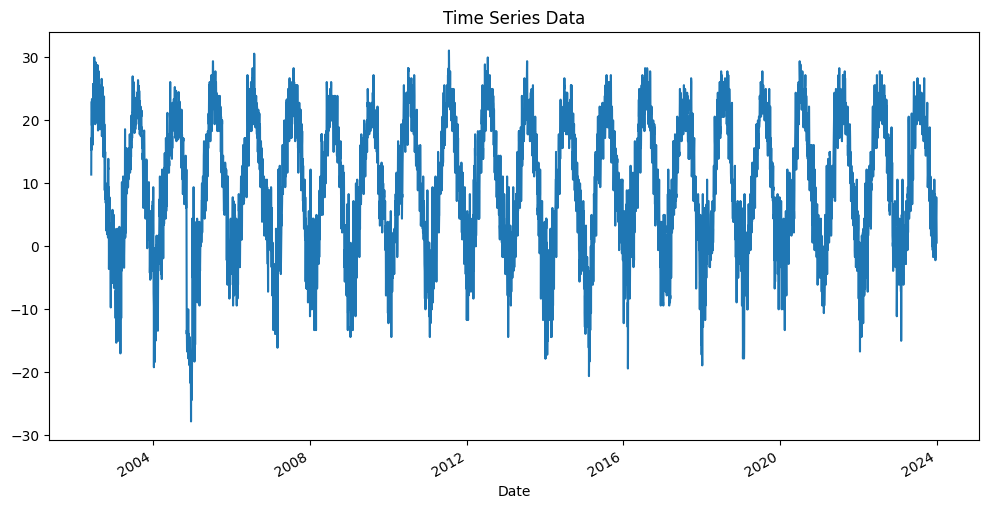

In [30]:
# Visualize the time series data
df['TAVG'].plot(figsize=(12, 6))
plt.title('Time Series Data')
plt.show()